In [1]:
# vikasan
import os
import findspark
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['SPARK_HOME'] = '/home/vik/spark-3.5.6-bin-hadoop3'  

findspark.init()

In [2]:
# vikasan
from pyspark import SparkContext
sc=SparkContext("local","Pyspark new")

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.executor.memory", "6G") \
    .config("spark.driver.memory", "6G") \
    .config("spark.sql.shuffle.partitions", "300") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()


25/10/29 15:25:50 WARN Utils: Your hostname, VKSN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/29 15:25:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/29 15:25:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import *
from pyspark.ml import Pipeline

In [4]:
statistical_anomalies = spark.read.parquet("file:///home/vik/BDA_miniproj/results/statistical_outliers.parquet")
topological_anomalies = spark.read.parquet("file:///home/vik/BDA_miniproj/results/topological_anomalies_clean.parquet")
behavioural_anomalies = spark.read.parquet("file:///home/vik/BDA_miniproj/results/final_behavioural_anomalies_m2.parquet")

In [5]:
print(f"Statistical Anomalies (Paths): {statistical_anomalies.count()}")
print(f"Topological Anomalies (New Paths): {topological_anomalies.count()}")
print(f"Behavioural Anomalies (Articles): {behavioural_anomalies.count()}")

Statistical Anomalies (Paths): 119506
Topological Anomalies (New Paths): 1141450
Behavioural Anomalies (Articles): 10


In [6]:
behavioural_anomalies.columns

['curr', 'features', 'prediction', 'distance_to_center']

In [7]:
statistical_anomalies.columns

['prev',
 'curr',
 'type',
 'n',
 'type_encoded',
 'normalized_clicks',
 'zscore',
 'abs_zscore']

In [8]:
topological_anomalies.columns

['prev', 'curr']

In [14]:
stat_articles = statistical_anomalies.select(col("curr").alias("article")).distinct()
topo_articles = topological_anomalies.select(col("curr").alias("article")).distinct()
behav_articles = behavioural_anomalies.select(col("curr").alias("article")).distinct()

In [15]:
common_all_3 = stat_articles.join(topo_articles, "article") \
                            .join(behav_articles, "article")
print(f"Articles flagged by ALL 3 methods: {common_all_3.count()}")
if common_all_3.count() > 0:
    common_all_3.show(truncate=False)

# Stat + Behav
common_stat_behav = stat_articles.join(behav_articles, "article")
print(f"Articles flagged by Statistical AND Behavioural: {common_stat_behav.count()}")
# if common_stat_behav.count() > 0:
#     common_stat_behav.show(truncate=False)

# Topo + Behav
common_topo_behav = topo_articles.join(behav_articles, "article")
print(f"Articles flagged by Topological AND Behavioural: {common_topo_behav.count()}")
# if common_topo_behav.count() > 0:
#     common_topo_behav.show(truncate=False) 

# Stat + Topo
common_stat_topo = stat_articles.join(topo_articles, "article")
print(f"Articles flagged by Statistical AND Topological: {common_stat_topo.count()}")
# if common_stat_topo.count() > 0:
#     common_stat_topo.show(truncate=False)

Articles flagged by ALL 3 methods: 5


+-----------------+
|article          |
+-----------------+
|Killed_in_action |
|Issue_(genealogy)|
|Main_Page        |
|Incumbent        |
|A                |
+-----------------+

Articles flagged by Statistical AND Behavioural: 5


Articles flagged by Topological AND Behavioural: 6


Articles flagged by Statistical AND Topological: 56913


In [11]:
anomalous_articles_behav = behavioural_anomalies.select(
    col("curr").alias("article"),
    col("distance_to_center")
)

anomalous_paths_stat = statistical_anomalies.groupBy("curr").agg(
    count("*").alias("hot_path_count"),
    avg("zscore").alias("avg_zscore")
).withColumnRenamed("curr", "stat_article") # to avoid ambiguous column

common_stat_behav_details = anomalous_articles_behav.join(
    anomalous_paths_stat,
    anomalous_articles_behav["article"] == anomalous_paths_stat["stat_article"],
    how="inner"
)

In [12]:
print(f"\nDetails for the {common_stat_behav_details.count()} Stat+Behav common anomalies:")
common_stat_behav_details.select(
    "article",
    "distance_to_center",
    "hot_path_count",
    "avg_zscore"
).orderBy(desc("distance_to_center")).show(truncate=False)


Details for the 5 Stat+Behav common anomalies:
+-----------------+------------------+--------------+------------------+
|article          |distance_to_center|hot_path_count|avg_zscore        |
+-----------------+------------------+--------------+------------------+
|Main_Page        |433915.1446972677 |20            |4.123577427271675 |
|A                |79571.3221524217  |1             |7.1803893195856725|
|Issue_(genealogy)|13659.204081669943|1             |3.461547060366284 |
|Incumbent        |1001.1277645012341|1             |3.2390137055078316|
|Killed_in_action |910.878038011247  |2             |3.52295686180159  |
+-----------------+------------------+--------------+------------------+



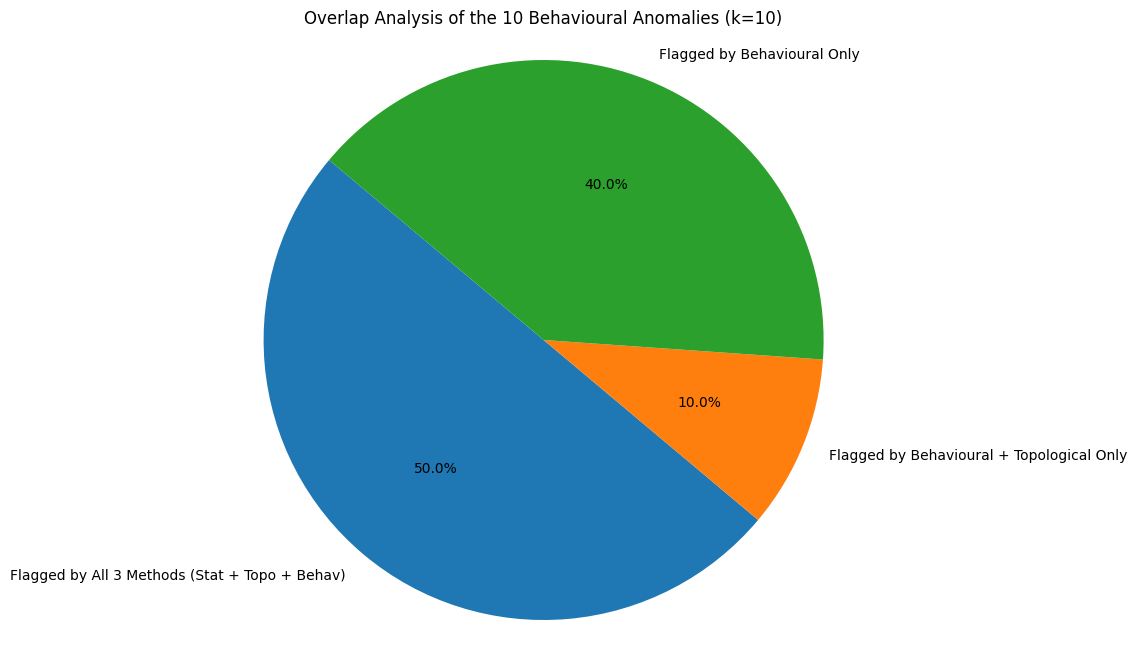

In [ ]:
import matplotlib.pyplot as plt

# Total Behavioural Anomalies = 10
counts = [
    5, # by All 3 Methods
    1, #  by Behavioural + Topological Only (6 total - 5 common to all)
    4  # by Behavioural Only (10 total - 5 common - 1 Topo)
]
labels = [
    'Flagged by All 3 Methods (Stat + Topo + Behav)',
    'Flagged by Behavioural + Topological Only',
    'Flagged by Behavioural Only'
]

plt.figure(figsize=(10, 8))
plt.pie(counts,
        labels=labels,
        autopct='%1.1f%%', # Show percentages
        startangle=140
    )

plt.title('Overlap Analysis of the 10 Behavioural Anomalies (k=10)')
plt.axis('equal') 
plt.show()

## statisitical anomaly

In [10]:
from pyspark.sql.functions import *
from pyspark.ml import Pipeline

In [11]:
train_df = spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/train_clickstream.parquet")
test_df = spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/final_test_clickstream_m2.parquet")

In [12]:
stats = train_df.select(
    mean("normalized_clicks").alias("mean_norm_clicks"),
    stddev("normalized_clicks").alias("stddev_norm_clicks")
).first()

mean_norm_clicks = stats["mean_norm_clicks"]
stddev_norm_clicks = stats["stddev_norm_clicks"]

print(f"Mean (normalized_clicks): {mean_norm_clicks}")
print(f"Standard Deviation (normalized_clicks): {stddev_norm_clicks}")

Mean (normalized_clicks): 3.6562865842334396
Standard Deviation (normalized_clicks): 1.1975899057217712


In [13]:
# use the training stats to calculate Z-scores for the test data
test_df2_with_zscore = test_df.withColumn(
    "zscore",
    (col("normalized_clicks") - mean_norm_clicks) / stddev_norm_clicks
)

test_df2_with_zscore = test_df2_with_zscore.withColumn("abs_zscore", abs(col("zscore")))

In [14]:
# Identify outlier navigation pairs in the test set
outlier_threshold = 3
statistical_outliers = test_df2_with_zscore.filter(col("abs_zscore") > outlier_threshold)

print(f"Found {statistical_outliers.count()} statistical outliers in the test set:")


Found 119506 statistical outliers in the test set:


In [27]:
# Show the most anomalous pairs (highest Z-score)
statistical_outliers.orderBy(desc("abs_zscore")).show(20, truncate=False)

+--------------+-------------------------------------+--------+---------+------------+------------------+------------------+------------------+
|prev          |curr                                 |type    |n        |type_encoded|normalized_clicks |zscore            |abs_zscore        |
+--------------+-------------------------------------+--------+---------+------------+------------------+------------------+------------------+
|other-empty   |Main_Page                            |external|164702497|1           |18.9196513620031  |12.745067994348732|12.745067994348732|
|other-search  |Coolie_(2025_film)                   |external|4745236  |1           |15.3726519360918  |9.783286662555048 |9.783286662555048 |
|other-empty   |Deaths_in_2025                       |external|1748261  |1           |14.37413270954942 |8.949512745647668 |8.949512745647668 |
|other-search  |Saiyaara                             |external|1632957  |1           |14.30590365208725 |8.892540774577949 |8.8925407745

## topological amomaly

In [14]:
baseline_edges = train_df.select("prev", "curr").distinct()

In [15]:
test_edges = test_df.select("prev", "curr").distinct()

In [16]:
topological_anomalies = test_edges.join(
    baseline_edges,
    on=["prev", "curr"],
    how="left_anti"
)

In [17]:
topological_anomalies.write.mode("overwrite").parquet(
    "file:///home/vik/BDA_miniproj/results/topological_anomalies_clean.parquet"
)

In [18]:
print("Number of anomalies:", topological_anomalies.count())

Number of anomalies: 1141450


In [22]:
topological_anomalies.show(10,truncate=False)

+--------------------------------------------+-------------------------------+
|prev                                        |curr                           |
+--------------------------------------------+-------------------------------+
|"I_Want"_song                               |High_School_Musical_(franchise)|
|"Pimpernel"_Smith                           |Ronald_Howard_(British_actor)  |
|'Orrible                                    |William_Boyde                  |
|'Til_the_Medicine_Takes                     |Widespread_Panic               |
|'Til_the_Rivers_All_Run_Dry                 |Don_Williams                   |
|(You're_My)_Soul_and_Inspiration            |Phil_Spector                   |
|(You_Gotta)_Fight_for_Your_Right_(To_Party!)|Hot_Sauce_Committee_Part_Two   |
|*Manu_and_*Yemo                             |Cattle_raiding                 |
|-phil-                                      |Bookworm                       |
|...And_the_Beast_from_the_Sea               |Nina_A

In [21]:
topological_anomalies.groupBy("curr").count().orderBy(desc("count")).show(10)

+-------------------+-----+
|               curr|count|
+-------------------+-----+
|          Main_Page| 7105|
|      United_States|  252|
|            YouTube|  230|
|                  A|  203|
|       World_War_II|  160|
|                 13|  151|
|      New_York_City|  146|
|Weapons_(2025_film)|  134|
|     United_Kingdom|  134|
|       Soviet_Union|  133|
+-------------------+-----+
only showing top 10 rows



## demo(sub-sampling) for kmeans

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import *

In [5]:
train_df= spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/train_clickstream.parquet").\
                            sample(withReplacement=False, fraction=0.03, seed=42)    #wsl-vik

In [6]:
print(f"Using a demo sample of {train_df.count()} rows.")

Using a demo sample of 1077273 rows.


In [7]:
# test set
test_df2 = spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/final_test_clickstream_m2.parquet")    #wsl-vik

In [8]:
in_agg = train_df.groupBy("curr").agg(
    countDistinct("prev").alias("in_degree"),              # distinct incoming sources
    sum(col("normalized_clicks")).alias("in_clicks"),     # sum of normalized inbound clicks
    count("*").alias("in_events")                         # number of inbound records (helpful)
)

out_agg = train_df.groupBy("prev").agg(
    countDistinct("curr").alias("out_degree"),              #countDistinct() - used  to count the no.of unique values within one or more columns of a DF
    sum(col("normalized_clicks")).alias("out_clicks"),
    count("*").alias("out_events")
).withColumnRenamed("prev", "curr")                         #withColumnRenamed() - used to rename a single existing column

In [9]:
article_features = in_agg.join(out_agg, on="curr", how="full_outer").fillna(0)

# Derived features (ratios and normalized rates)
article_features = article_features.withColumn(
    "ratio_out_in", (col("out_clicks") / (col("in_clicks") + lit(1.0)))         #lit() is used to create col with a constant or literal value within a DF
).withColumn(
    "bounce_rate", 1 - (col("out_clicks") / (col("in_clicks") + lit(1.0)))
).withColumn(
    "in_out_event_ratio", (col("in_events") / (col("out_events") + lit(1.0)))
)


In [10]:
feature_cols = [
    "in_degree", "out_degree",
    "in_clicks", "out_clicks",
    "ratio_out_in", "bounce_rate", "in_out_event_ratio"
]

In [11]:
article_features.select("curr", *feature_cols).show(10, truncate=False)
print("Total articles:", article_features.count())

+--------------------------------------------------------------+---------+----------+------------------+------------------+------------------+-------------------+------------------+
|curr                                                          |in_degree|out_degree|in_clicks         |out_clicks        |ratio_out_in      |bounce_rate        |in_out_event_ratio|
+--------------------------------------------------------------+---------+----------+------------------+------------------+------------------+-------------------+------------------+
|!!                                                            |2        |1         |5.886104031450156 |2.639057329615259 |0.3832438948877593|0.6167561051122408 |1.0               |
|!!!                                                           |1        |0         |4.430816798843313 |0.0               |0.0               |1.0                |1.0               |
|!Oka_Tokat                                                    |2        |0         |5.231

Total articles: 1024497


In [12]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=10, seed=42)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])
pipeline_model = pipeline.fit(article_features)

# Extract trained models for later reuse
scaler_model = pipeline_model.stages[1]
kmeans_model = pipeline_model.stages[2]

print("K-means model trained on Month 1 data.")
print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

K-means model trained on Month 1 data.
Cluster Centers:
[-0.29715649  0.00192032 -0.33405712  0.00126013  0.00251476 -0.00251476
 -1.23142309]
[ 9.45275017e+02  3.63347844e+01  9.20977962e+02  3.18284056e+01
 -7.84398806e-05  7.84398806e-05 -5.76481126e-01]
[-2.99032905e-01  6.80861850e+02 -3.35845326e-01  6.93799321e+02
  6.94150813e+02 -6.94150813e+02 -1.23276180e+00]
[ 0.91045463  0.00898331  1.1052833   0.00903579 -0.00236477  0.00236477
  0.6236737 ]
[ 1.30000574e+00 -3.86322936e-03  1.45232566e+00 -3.52664338e-03
 -3.06956067e-03  3.06956067e-03  6.01409254e+00]
[-0.00235573 -0.00468791 -0.01433076 -0.00433175 -0.00307745  0.00307745
  0.31013925]
[ 0.36253692 -0.00454184  0.42234637 -0.00418685 -0.00308079  0.00308079
  2.09317083]
[  -0.2990329   249.2259435    -0.33584533  217.80790415  217.91921954
 -217.91921954   -1.2327618 ]
[ 4.05940529e+00  3.35687565e-02  4.50102996e+00  3.48677685e-02
 -2.38802386e-03  2.38802386e-03  1.73044658e+00]
[ 0.04936333  0.00365677  0.0822366

In [13]:
in_agg_m2 = test_df2.groupBy("curr").agg(
    countDistinct("prev").alias("in_degree"),
    sum(col("normalized_clicks")).alias("in_clicks"),
    count("*").alias("in_events")
)

out_agg_m2 = test_df2.groupBy("prev").agg(
    countDistinct("curr").alias("out_degree"),
    sum(col("normalized_clicks")).alias("out_clicks"),
    count("*").alias("out_events")
).withColumnRenamed("prev", "curr")

article_features_m2 = in_agg_m2.join(out_agg_m2, on="curr", how="full_outer").fillna(0)

article_features_m2 = article_features_m2.withColumn(
    "ratio_out_in", (col("out_clicks") / (col("in_clicks") + lit(1.0)))
).withColumn(
    "bounce_rate", 1 - (col("out_clicks") / (col("in_clicks") + lit(1.0)))
).withColumn(
    "in_out_event_ratio", (col("in_events") / (col("out_events") + lit(1.0)))
)

# Assembling Month 2 features
feature_cols = [
    "in_degree", "out_degree",
    "in_clicks", "out_clicks",
    "ratio_out_in", "bounce_rate", "in_out_event_ratio"
]

In [14]:
assembled_m2 = assembler.transform(article_features_m2)

In [15]:
scaled_test_df = scaler_model.transform(assembled_m2).select("curr", "features")
print("Month 2 data successfully scaled using Month 1's rules.")

Month 2 data successfully scaled using Month 1's rules.


In [16]:
predictions_m2 = kmeans_model.transform(scaled_test_df)

cluster_centers = kmeans_model.clusterCenters()

In [17]:
def get_distance(features, prediction):
    center = cluster_centers[prediction]
    return float(features.squared_distance(center))

In [18]:
distance_udf = udf(get_distance, DoubleType())

anomalies_df = predictions_m2.withColumn(
    "distance_to_center",
    distance_udf(col("features"), col("prediction"))
)

In [19]:
distance_stats = anomalies_df.select(
    mean("distance_to_center").alias("mean_distance"),
    stddev("distance_to_center").alias("stddev_distance")
).first()

mean_distance = distance_stats["mean_distance"]
stddev_distance = distance_stats["stddev_distance"]

print(f"Mean Distance (Month 1): {mean_distance}")
print(f"StdDev Distance (Month 1): {stddev_distance}")

Mean Distance (Month 1): 60.73251211209211
StdDev Distance (Month 1): 59797.29228216281


In [20]:
anomaly_threshold = mean_distance + (3 * stddev_distance)
print(f"Anomaly Threshold (Distance > {anomaly_threshold}):")

final_behavioural_anomalies = anomalies_df.filter(
    col("distance_to_center") > anomaly_threshold
)

Anomaly Threshold (Distance > 179452.60935860052):


In [33]:
print(f"Found {final_behavioural_anomalies.count()} formally classified behavioural anomalies in Month 2:")
final_behavioural_anomalies.orderBy(desc("distance_to_center")).show(truncate=False)

Found 5 formally classified behavioural anomalies in Month 2:


25/10/28 08:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/10/28 08:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/10/28 08:50:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/10/28 08:50:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------+
|curr          |features                                                                                                                                         |prediction|distance_to_center |
+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------+
|other-empty   |[-0.29903290464061344,5067.854531831927,-0.33584532596657535,4783.387836792241,4785.802860547091,-4785.802860547086,-1.2327617958472552]         |2         |6.945367197001752E7|
|Main_Page     |[6694.080854672584,251.34141834302864,6524.571218462289,222.66857664976078,-1.1534895042959579E-4,1.1534895042961575E-4,-0.5609301477030884]     |1         |6.453167377216124E7|
|other-search  |[-0.2990329046